This Deep Learning Keras model identifies whether a potato plant is healthy or if it has early or late blight disease using pictures of the plant's leaves. The dataset was obtained from kaggle (Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village)

Importing the libraries

In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Setting the constants

In [51]:
imageSize = 256
batchSize = 32
rgbChannels = 3
epoch = 10

Loading all the images to a tensorflow dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (imageSize, imageSize),
    batch_size = batchSize
)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [6]:
for images_batch, label_batch in dataset.take(1):
    print(images_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 2 0 0 0 2 0 1 0 1 0 2 0 0 1]


Visualizing some of the images in the dataset. The labels are also shown.

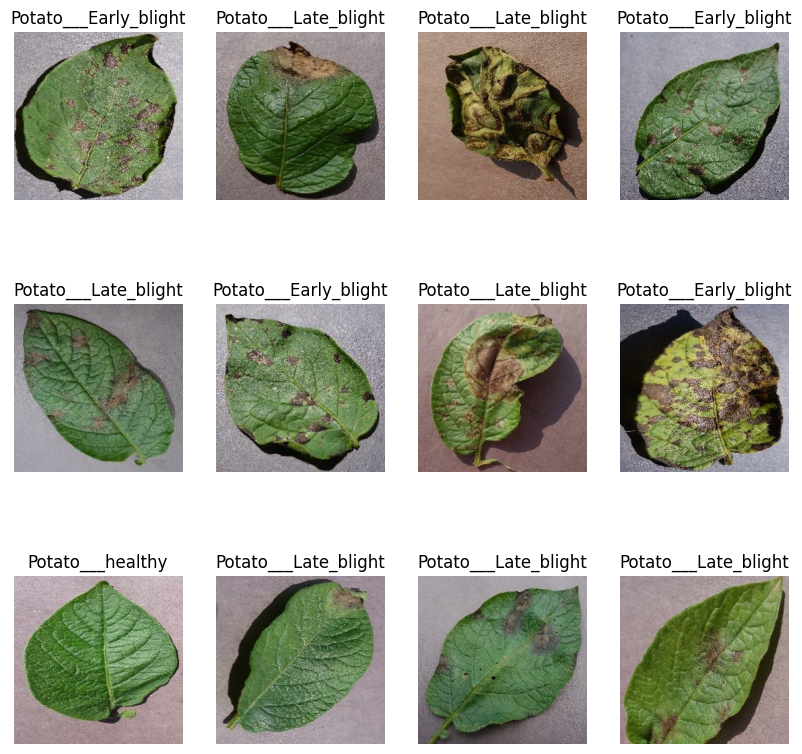

In [7]:
plt.figure(figsize = (10,10))
for images_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

The dataset is split into 3 subsets:

1. Training: Data that's used for training
2. Validation: Data that's used to test while training
3. Testing: Data that's used to test the model after training

80% of the data is used for training. 10% of the data is used for validation, and the rest of the data is used for testing.

In [9]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [10]:
train_set = dataset.take(54)

In [11]:
test_set = dataset.skip(54)

In [12]:
validation_set_size = 0.1
len(dataset) * validation_set_size

6.800000000000001

In [13]:
validation_set = test_set.take(6)
len(validation_set)

6

In [14]:
test_set = test_set.skip(6)

This function shuffles and partitions the data as described before.

In [15]:
def get_dataset_partitions_tf(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)

    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [16]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

54 6 8


We now use model optimization techniques like cache and prefetch to make the training more efficient.

In [18]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Now we start building the model. We first have to resize the image before feeding it to the neural network. To improve model performance we also normalize the image pixel values.

In [19]:
resize_and_rescale = tf.keras.Sequential ([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data augmentation helps if we have less data. It also improves the model's efficiency.

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

Model Architecture.

CNN (Convolutional Neural Network) is used here as it is better suited to handle image classifcation. After we build the initial resizing and data augmentation layers, we build the hidden layers that use a ReLu activation function. The output layer uses the softmax activation function.

In [47]:
input_shape = (batchSize, imageSize, imageSize, rgbChannels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [48]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_10 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [49]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ["accuracy"]
)

In [52]:
history = model.fit(
    train_dataset,
    epochs = epoch,
    batch_size = batchSize,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/10
54/54 [==============================] - 68s 1s/step - loss: 0.1932 - accuracy: 0.9277 - val_loss: 0.3151 - val_accuracy: 0.8594
Epoch 2/10
54/54 [==============================] - 66s 1s/step - loss: 0.1470 - accuracy: 0.9450 - val_loss: 0.1717 - val_accuracy: 0.9115
Epoch 3/10
54/54 [==============================] - 62s 1s/step - loss: 0.1562 - accuracy: 0.9392 - val_loss: 0.2370 - val_accuracy: 0.8854
Epoch 4/10
54/54 [==============================] - 64s 1s/step - loss: 0.1602 - accuracy: 0.9381 - val_loss: 0.3290 - val_accuracy: 0.8854
Epoch 5/10
54/54 [==============================] - 63s 1s/step - loss: 0.1290 - accuracy: 0.9491 - val_loss: 0.1320 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 62s 1s/step - loss: 0.1427 - accuracy: 0.9485 - val_loss: 0.1490 - val_accuracy: 0.9375
Epoch 7/10
54/54 [==============================] - 61s 1s/step - loss: 0.1120 - accuracy: 0.9554 - val_loss: 0.1422 - val_accuracy: 0.9375
Epoch 8/10
54/54 [==

The model is now compiled and fit. The accuracy of the model is around 96%. The accuracy may be increased further by increasing the number of epochs.

In [53]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 3s 212ms/step - loss: 0.0996 - accuracy: 0.9648


In [54]:
scores

[0.09959113597869873, 0.96484375]

In [56]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [57]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
history.history['accuracy']

[0.9276620149612427,
 0.9450231194496155,
 0.9392361044883728,
 0.9380787014961243,
 0.9490740895271301,
 0.9484953880310059,
 0.9554398059844971,
 0.9612268805503845,
 0.9618055820465088,
 0.9502314925193787]

Accuracy and loss curves are now plotted to visualize how accuracy increases and the loss decreases as the model was being trained.

In [59]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

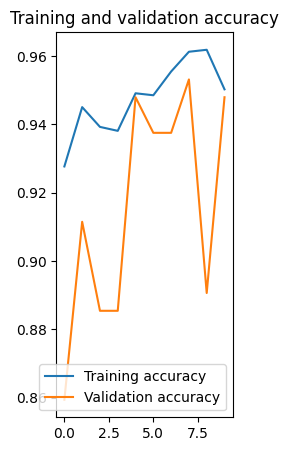

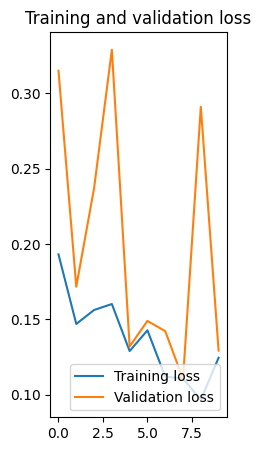

In [68]:
plt.figure(figsize = (5,5))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), accuracy, label = 'Training accuracy')
plt.plot(range(epoch), val_accuracy, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

plt.figure(figsize = (5,5))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), loss, label = 'Training loss')
plt.plot(range(epoch), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and validation loss')

To test the model to see for ourselves, a random image was plotted and it is seen that the model has identified the potato plant's leaf's condition correctly.

test prediction
actual label: Potato___Early_blight
1/1 [==============================] - 0s 223ms/step
predicted label: Potato___Early_blight


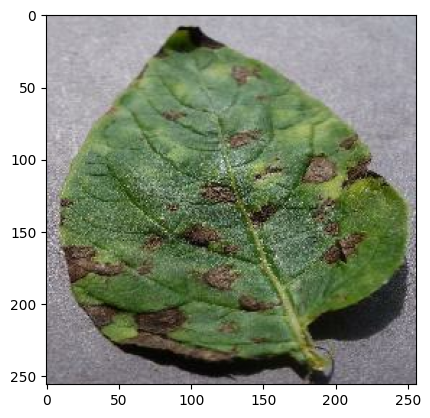

In [74]:
import numpy as np

for images_batch, label_batch in dataset.take(1):
    test_image = images_batch[0].numpy().astype('uint8')
    test_label = label_batch[0].numpy()

    print("test prediction")
    plt.imshow(test_image)
    print("actual label:", classes[test_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", classes[np.argmax(batch_prediction[0])])

A classification report is also compiled to get a deeper insight on the performance of the model.

In [75]:
from sklearn.metrics import classification_report
pred = model.predict(images_batch)
pred_labels = [np.argmax(element) for element in pred]

print("Classification Report: \n", classification_report(label_batch, pred_labels))

1/1 [==============================] - 0s 270ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.75      1.00      0.86         3

    accuracy                           0.97        32
   macro avg       0.92      0.98      0.94        32
weighted avg       0.98      0.97      0.97        32

